## 4\. Model Building

Now that we have the data ready, its time to start making predictive models. I will go through 5 scikit-learn simple models including linear regression, decision tree and random forest.

Since I’ll be making many models, instead of repeating the codes again and again, I would like to define a generic function which takes the algorithm and data as input and makes the model, performs cross-validation and generates submission.

I'll do the same thing later with H2O and XGboost

In [1]:
import pandas as pd
import numpy as np
import time
import csv
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import math

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [2]:
#now we load our modified train and test set

tic()
#train = pd.read_csv('./input-data/train_modified.csv', nrows = 500000)
#test = pd.read_csv('./input-data/test_modified.csv', nrows = 500000)
train = pd.read_csv('./input-data/train_modified_5lags.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                   )
                    
val = pd.read_csv('./input-data/val_modified_5lags.csv',
                    dtype = {'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'log_target':  'float64',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean':  'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                   ) 
    
test = pd.read_csv('./input-data/test_modified_5lags.csv',
                    dtype = {'id': 'uint32',
                            'Semana': 'int8',
                            'Agencia_ID': 'uint16',
                            'Canal_ID': 'int8',
                            'Ruta_SAK': 'int32',
                            'Cliente_ID': 'int32',
                            'Producto_ID': 'int32',
                            'Log_Target_mean_lag1': 'float64',
                            'Log_Target_mean_lag2': 'float64',
                            'Log_Target_mean_lag3': 'float64',
                            'Log_Target_mean_lag4': 'float64',
                            'Log_Target_mean_lag5': 'float64',
                            'rate_change2': 'float64',
                            'rate_change3': 'float64',
                            'rate_change4': 'float64',
                            'Lags_sum': 'float64',
                            'pairs_mean': 'float64',
                            'brand': 'uint16',
                            'cluster': 'uint16',
                            'Qty_Ruta_SAK_Bin': 'int8',
                            'ZipCode': 'uint16',
                            'week_ct': 'int8',
                            'NombreCliente': 'int8',
                            'Producto_ID_clust_ID':'int8',
                            'Ruta_SAK_clust_ID':'int8',
                            'Agencia_ID_clust_ID':'int8'},
                      )
tac()

Time passed: 0hour:1min:34sec


In [7]:
val.head()

,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,log_target,Log_Target_mean_lag1,Log_Target_mean_lag2,Log_Target_mean_lag3,...,Lags_sum,brand,cluster,Qty_Ruta_SAK_Bin,ZipCode,week_ct,NombreCliente,Producto_ID_clust_ID,Ruta_SAK_clust_ID,Agencia_ID_clust_ID
0,9,1110,7,3301,15766,1212,0.693147,1.609438,0.000000,0.000000,...,5.010635,1,18,1,2008,1,11,48,3,22
1,9,1110,7,3301,73844,1212,1.386294,1.098612,1.098612,1.386294,...,5.780744,1,18,1,2008,1,11,48,3,22
2,9,1110,7,3301,181232,1212,1.098612,1.098612,1.098612,0.000000,...,2.197225,1,18,2,2008,1,2,48,3,22
3,9,1110,7,3301,988589,1212,0.693147,0.693147,0.693147,0.693147,...,2.772589,1,18,1,2008,1,8,48,3,22
4,9,1110,7,3301,1159580,1212,1.386294,1.609438,1.098612,1.791759,...,6.984716,1,18,1,2008,1,11,48,3,22


In [5]:
#Define target and ID columns:
target = 'log_target'
IDcol = 'id'

In [3]:
#   rmsle - error function used in LB
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(max(0,y_pred[i]) + 1) - math.log(max(0,y[i]) + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5


from sklearn import cross_validation, metrics

def modelfit(alg, dtrain, dval, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    y = alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Predict validation (holdout) set:
    dval_predictions = alg.predict(dval[predictors])

    #Perform cross-validation: We are not using CV since the data has a temporal behavior, aka, time series.
    #cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=2, scoring='mean_squared_error')
    #cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    #print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    #print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #RMSLE Option 1: - using the rsmle function defined above
    #print ('RMSLE TRAIN: ', rmsle(np.expm1(dtrain[target].values), np.expm1(dtrain_predictions)))  
    #print ('RMSLE VAL: ', rmsle(np.expm1(dval[target].values), np.expm1(dval_predictions)))
    
    #RMSLE Option 2: the fastest one
    print ('RMSLE TRAIN: ', np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ('RMSLE VAL: ', np.sqrt(metrics.mean_squared_error(dval[target].values, dval_predictions)))
    
        
    #Predict on testing data: we need to revert it back to target by applying expm1
    dtest[target] = np.expm1(alg.predict(dtest[predictors]))
    
    print ('NUM ROWS PREDICTED: ', dtest.shape[0] )
    print ('NUM NEGATIVES PREDICTED: ', dtest[target][dtest[target] < 0].count())
    print ('MIN TARGET PREDICTED: ', dtest[target].min())
    print ('MEAN TARGET PREDICTED: ', dtest[target].mean())
    print ('MAX TARGET PREDICTED: ', dtest[target].max())
    
    dtest[target] = np.maximum(dtest[target], 0) # we make all negative numbers = 0 since there cannot be a negative demand
    
    #Export submission file:
    #IDcol.append(target)
    #submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission = dtest[[IDcol,target]].copy()
    submission[IDcol] = submission[IDcol].astype(int)
    submission.rename(columns={target: 'Demanda_uni_equil'}, inplace=True)
    submission.to_csv("./Submissions/"+filename, index=False)
    

Let's define now the target and the Id cols

### Alg1 - Linear Regression Model

Lets make our first linear-regression model


Model Report
RMSLE TRAIN:  0.625065037958
RMSLE VAL:  1174997406.64
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  6999251
MIN TARGET PREDICTED:  -1.0
MEAN TARGET PREDICTED:  -1.0
MAX TARGET PREDICTED:  -1.0
Time passed: 0hour:0min:51sec


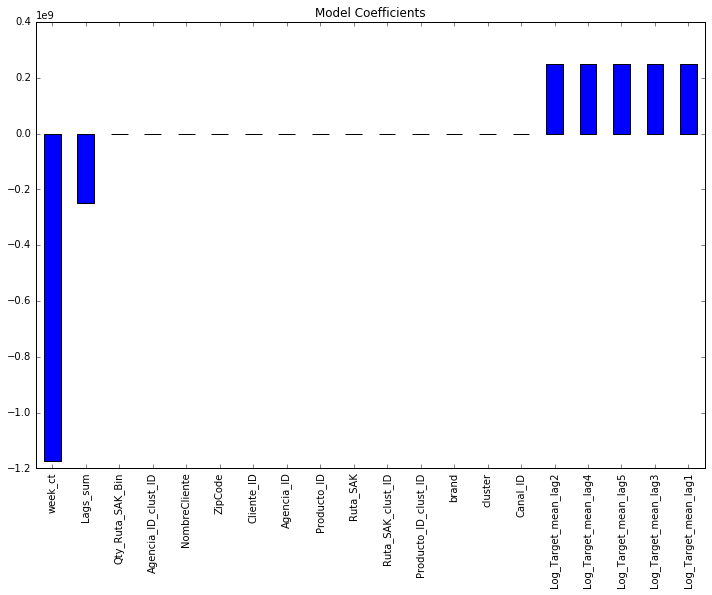

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+[IDcol]]

# print predictors
model = LinearRegression(normalize=True)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg1.csv')
tac()
coef1 = pd.Series(model.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

## --> LB: 0.50568

If we notice the coefficients, they are very large in magnitude which signifies overfitting. To cater to this, lets use a ridge regression model.

### Alg2 - Ridge Regression Model:


Model Report
RMSLE TRAIN:  0.612489504908
RMSLE VAL:  0.611882382619
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.945305741577
MEAN TARGET PREDICTED:  3.0471952765230697
MAX TARGET PREDICTED:  204.842641299
Time passed: 0hour:0min:54sec


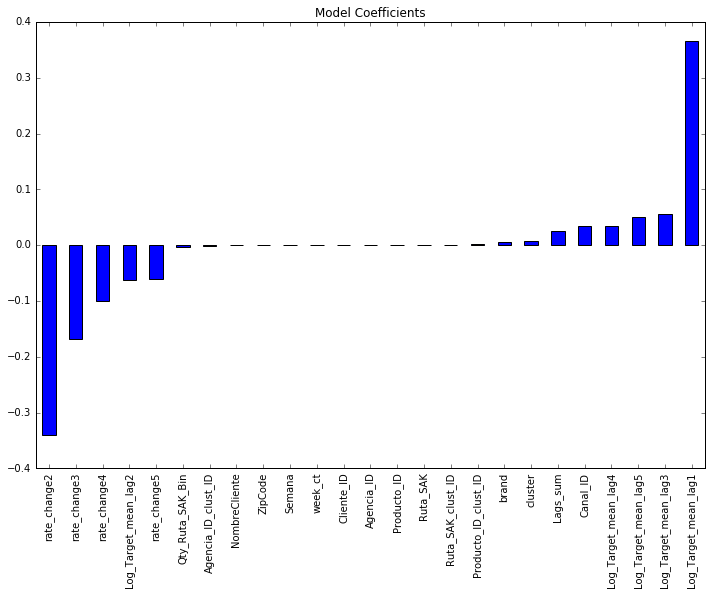

In [9]:
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
model = Ridge(alpha=0.05,normalize=True)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg2.csv')
tac()
coef2 = pd.Series(model.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

Though the regression coefficient look better now, we noticed the pairs_mean is taking all the weight/importance. We can tune the parameters of the model  but I don’t think there will be a significant improvement with linear regression.

### Alg3 - Decision Tree Model

Lets try out a decision tree model and see if we get something better.


Model Report
RMSLE TRAIN:  0.417350214004
RMSLE VAL:  0.514789184508
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0
MEAN TARGET PREDICTED:  5.880622590886897
MAX TARGET PREDICTED:  255.490063744
Time passed: 0hour:4min:30sec


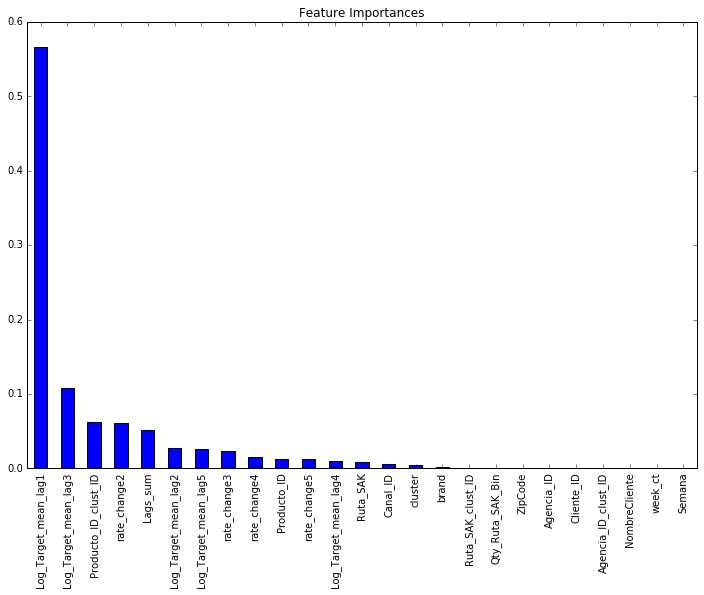

In [10]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
model = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg3.csv')
tac()
coef3 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

We start seeing a pattern here, RSMLE VAL is great, but RSMLE on test data (LB score) is not even close. It looks like pairs_mean is a good average for a base line, but it is not good at predicting.

## --> LB: 

### Alg4 - Decision Tree Model v2

Lets try making a decision tree with just 7 variables, a max_depth of 25 and min_samples_leaf as 150.


Model Report
RMSLE TRAIN:  0.357145958378
RMSLE VAL:  0.522852873537
NUM ROWS PREDICTED:  6999251
NUM NEGATIVES PREDICTED:  0
MIN TARGET PREDICTED:  0.0
MEAN TARGET PREDICTED:  6.060654986528017
MAX TARGET PREDICTED:  163.294624816
Time passed: 0hour:4min:16sec


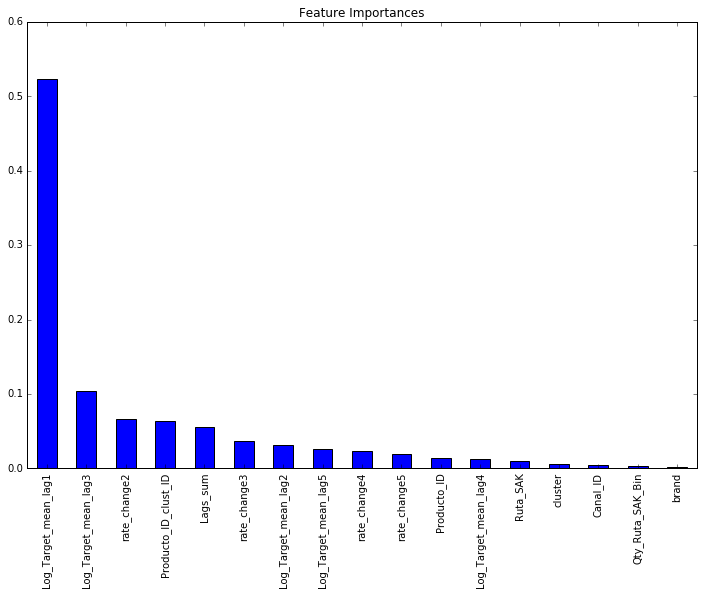

In [11]:
predictors = ['Canal_ID','Ruta_SAK','Producto_ID','Log_Target_mean_lag1',
              'Log_Target_mean_lag2','Log_Target_mean_lag3','Log_Target_mean_lag4', 'Log_Target_mean_lag5',
              'rate_change2','rate_change3','rate_change4','rate_change5','Lags_sum','brand','cluster','Qty_Ruta_SAK_Bin',
              'Producto_ID_clust_ID']
model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=150)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg4.csv')
tac()
coef4 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

## --> LB: 0.51100

The good news about this change is that: 1) score is better than using all features and 2) the RSMLE VAL (on hold-out set) is very close to RSMLE TEST, which means that we are not overfitting and actually predicting better.

Let's tray some ensembling algos, starting with Random Forest

### Alg5 - Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+[IDcol]]
model = RandomForestRegressor(n_estimators=100,max_depth=25, min_samples_leaf=150,n_jobs=-1)
tic()
modelfit(model, train, val, test, predictors, target, IDcol, 'alg5.csv')
tac()
coef5 = pd.Series(model.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

## --> LB: 0.50359

As expected, better than a single tree. 